In [136]:
from tqdm import tqdm
import csv
import pickle
import PIL.Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torchvision import transforms, datasets

%matplotlib inline

# Table of Contents

* [Preprocessing](#Preprocessing)
* [Model](#Model)
* [Training](#Training)
* [Testing](#Testing)

# Preprocessing

In [2]:
# load training images
with open('./Vision_task_dataset_public/train_image.pkl', 'rb') as f:
    images = pickle.load(f)
images = np.array(images)

# load labels
with open('./Vision_task_dataset_public/train_label.pkl', 'rb') as f:
    labels = pickle.load(f)
labels = np.array(labels)

images.shape, labels.shape

((8000, 784), (8000,))

### Labels: 4

In [3]:
# check labels
np.unique(labels)

array([0, 2, 3, 6])

In [4]:
# test labels at regular interval
labels[0], labels[2000], labels[4000], labels[7999]

(0, 2, 3, 6)

Looks like data's sequentially arranged as per labels!

**Convert labels into 0, 1, 2 and 3 respectively as PyTorch expects them in this format.**

In [7]:
labels[labels == 2] = 1
labels[labels == 3] = 2
labels[labels == 6] = 3

In [8]:
# check labels
print(np.unique(labels))
labels[0], labels[2000], labels[4000], labels[7999]

[0 1 2 3]


(0, 1, 2, 3)

### Images

In [9]:
images[0].shape

(784,)

In [10]:
np.sqrt(784)

28.0

It seems that every image is a square of size 28x28.

(28, 28)


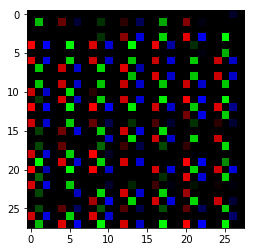

In [22]:
img = images[0].reshape(28, 28)
print(img.shape)
img = PIL.Image.fromarray(img, mode='RGB')
plt.imshow(img)

(28, 28)


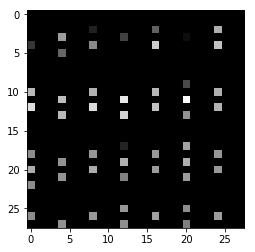

In [12]:
img = images[4000].reshape(28, 28)
print(img.shape)
img = PIL.Image.fromarray(img, mode='L')
plt.imshow(img)

<div style="color:red">Looks something off!</div>  
Trying in a different way...

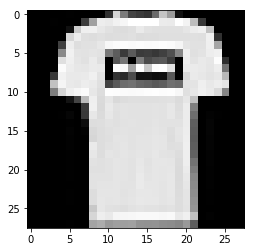

In [13]:
plt.imshow(images[0].reshape(1, 28, 28).squeeze(), cmap='Greys_r')

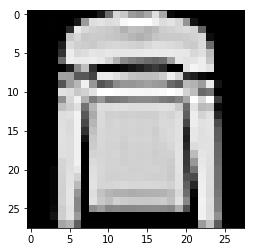

In [14]:
plt.imshow(images[2000].reshape(28, 28), cmap='Greys_r')

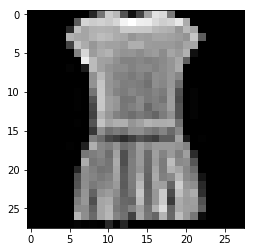

In [15]:
plt.imshow(images[4000].reshape(28, 28), cmap='Greys_r')

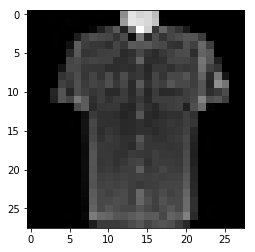

In [16]:
plt.imshow(images[7999].reshape(28, 28), cmap='Greys_r')

### Create PyTorch datasets and DataLoaders

First split data using  sklearn `train_test_split` then convert into tensor

In [19]:
# randomly split the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=0)

In [20]:
# convert into pytorch tensors
X_train = torch.stack([torch.from_numpy(np.array(i)) for i in X_train])
X_test = torch.stack([torch.from_numpy(np.array(i)) for i in X_test])
y_train = torch.stack([torch.from_numpy(np.array(i)) for i in y_train])
y_test = torch.stack([torch.from_numpy(np.array(i)) for i in y_test])

In [35]:
# reshape into [C, H, W]
X_train = X_train.reshape((-1, 1, 28, 28)).float()
X_test = X_test.reshape((-1, 1, 28, 28)).float()

In [36]:
# create dataset and dataloaders
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)

valid_dataset = torch.utils.data.TensorDataset(X_test, y_test)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64)

In [37]:
len(train_loader)

100

In [38]:
# for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [39]:
dataiter = iter(train_loader)
tt, ll = dataiter.next()
print(type(ll))
print(tt.shape)
print(ll.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


Now, everything seems perfect!  
<div style="color:green">Ready to move on...</div>

# Model

In [40]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 4)

        # dropout 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # flatten tensor
        x = x.view(x.shape[0], -1)

        # forward pass
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))

        # output so no dropout here
        x = self.fc4(x)

        return x


In [41]:
model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 30
steps = 0

In [42]:
print(model)

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=4, bias=True)
  (dropout): Dropout(p=0.2)
)


In [43]:
from torchsummary import summary
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
           Dropout-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
           Dropout-4                  [-1, 128]               0
            Linear-5                   [-1, 64]           8,256
            Linear-6                    [-1, 4]             260
Total params: 242,372
Trainable params: 242,372
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.92
Estimated Total Size (MB): 0.93
----------------------------------------------------------------


# Training

In [46]:
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        
        optimizer.zero_grad()
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        valid_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            # set model to evaluation mode
            model.eval()

            for images, labels in valid_loader:
                outputs = model(images)
                valid_loss += criterion(outputs, labels)
                
#                 ps = torch.exp(log_ps)
#                 top_p, top_class = ps.topk(1, dim=1)
#                 equals = top_class == labels.view(*top_class.shape)
#                 accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        # set model back to training mode
        model.train()
        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(valid_loss/len(valid_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(valid_loss/len(valid_loader)))
#               "Test Accuracy: {:.3f}".format(accuracy/len(valid_loader)))


Epoch: 1/30..  Training Loss: 0.593..  Test Loss: 0.556.. 
Epoch: 2/30..  Training Loss: 0.566..  Test Loss: 0.571.. 
Epoch: 3/30..  Training Loss: 0.529..  Test Loss: 0.527.. 
Epoch: 4/30..  Training Loss: 0.500..  Test Loss: 0.532.. 
Epoch: 5/30..  Training Loss: 0.513..  Test Loss: 0.507.. 
Epoch: 6/30..  Training Loss: 0.482..  Test Loss: 0.592.. 
Epoch: 7/30..  Training Loss: 0.485..  Test Loss: 0.483.. 
Epoch: 8/30..  Training Loss: 0.472..  Test Loss: 0.507.. 
Epoch: 9/30..  Training Loss: 0.458..  Test Loss: 0.480.. 
Epoch: 10/30..  Training Loss: 0.453..  Test Loss: 0.489.. 
Epoch: 11/30..  Training Loss: 0.442..  Test Loss: 0.480.. 
Epoch: 12/30..  Training Loss: 0.449..  Test Loss: 0.488.. 
Epoch: 13/30..  Training Loss: 0.412..  Test Loss: 0.523.. 
Epoch: 14/30..  Training Loss: 0.421..  Test Loss: 0.500.. 
Epoch: 15/30..  Training Loss: 0.401..  Test Loss: 0.482.. 
Epoch: 16/30..  Training Loss: 0.406..  Test Loss: 0.473.. 
Epoch: 17/30..  Training Loss: 0.405..  Test Loss

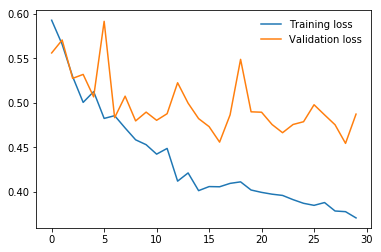

In [47]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

# Testing

In [49]:
# load testing data
with open('./Vision_task_dataset_public/test_image.pkl', 'rb') as f:
    test = pickle.load(f)
test = np.array(test)
test.shape

(2000, 784)

In [50]:
# convert into pytorch tensor
test = torch.stack([torch.from_numpy(np.array(i)) for i in test])

In [51]:
# reshape into [B, C, H, W]
test = test.reshape((-1, 1, 28, 28)).float()
test.shape, test.dtype

(torch.Size([2000, 1, 28, 28]), torch.float32)

<div style="color:blue">Check prediction on single image</div>

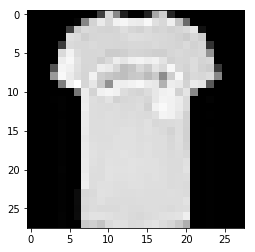

In [123]:
plt.imshow(test[0].reshape(1, 28, 28).squeeze(), cmap='Greys_r')

In [109]:
# convert output probabilities to predicted class
_, preds = torch.max(model(test[0].unsqueeze_(0)), 1)
preds.item()

0

Looks like the correct predicted value!  

**<div style="color:blue">Prediction on all test images</div>**

In [119]:
result = []
for i in range(len(test)):
    _, preds = torch.max(model(test[i].unsqueeze_(0)), 1)
    result.append(preds.item())
result = np.array(result)

In [120]:
result[:300]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 3, 0, 3, 0, 0, 0, 3, 3, 3, 3, 0,
       0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 0, 3, 0, 2, 3, 0, 0, 0, 1, 0, 0, 0, 0])

**Convert labels back to 6, 3, 2, and 0 from 3, 2, 1, and 0 respectively.**

In [121]:
result[result == 3] = 6
result[result == 2] = 3
result[result == 1] = 2

In [122]:
result[:300]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 6, 0, 0, 6, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 6, 6, 0, 6, 0, 0, 0, 6, 6, 6, 6, 0,
       0, 0, 0, 0, 3, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 0, 0,
       0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0,
       0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 6, 0, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       6, 6, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6,
       0, 0, 6, 0, 3, 6, 0, 0, 0, 2, 0, 0, 0, 0])

In [144]:
rows = zip(range(len(result)), result)

In [145]:
with open('harshitkumar.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['image_index', 'class'])
    for row in rows:
        writer.writerow(row)